<a href="https://colab.research.google.com/github/nackjaylor/sydney-innovation-program/blob/main/sip_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning (Semantic Segmentation)

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torchvision import models

model = models.segmentation.deeplabv3_resnet50(pretained=True, progress = True)
model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, 3)

model.train()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [10]:
batch_size = 32
img_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()    
])

train_dataset = datasets.OxfordIIITPet(root='./data/OxfordIITPET', download=True, target_types = "segmentation", transform=img_transform, target_transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# train_dataloader = train_dataset
test_dataset = datasets.OxfordIIITPet(root='./data/OxfordIITPET', download=True, split="test", target_types = "segmentation", transform=img_transform, target_transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = test_dataset

<Figure size 432x288 with 0 Axes>

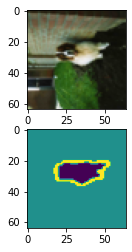

In [15]:
import numpy as np
train_features, train_labels = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(img.T)
axarr[1].imshow(label.T)
plt.show()

In [5]:
criterion = torch.nn.MSELoss(reduction='mean')
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
epochs = 20


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_loss_avg = []
model.to(device)
print('Training ...')
for epoch in range(epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, mask_batch in train_dataloader:
        
        image_batch = image_batch.to(device)
        
        
        segment_predict = model(image_batch)
        
        # reconstruction error
        loss = criterion(segment_predict['out'], mask_batch.to(device))
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average error: %f' % (epoch+1, epochs, train_loss_avg[-1]))

Training ...


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1 / 20] average error: 0.000532
Epoch [2 / 20] average error: 0.000214
Epoch [3 / 20] average error: 0.000122
